In [39]:
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import numpy as np
import pandas as pd
import math
#import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.ticker as ticker
from matplotlib import rc

def custom_grouping(index):
    return index // 1000

names_bw=['time', 'bw', 'op1', 'size', 'op2' ]
names_latency=['time', 'latency', 'op2', 'write_size', 'op3']

In [40]:
# Define a custom grouping function
  
names_latency=['submission_time', 'duration', 'op2', 'write_size', 'op3']
columns = ['submission_time', 'duration', 'write_size']

# Step 1: Read the CSV file into a Pandas DataFrame
df = pd.read_csv('/home/surbhi/measurements/worst_case/lsdm/lsdm-util/90Util/1MB/8TB/90-10-LBA/45GB/lat_log_avg_lat.1.log', names=names_latency)
#df = pd.read_csv('/home/surbhi/measurements/worst_case/lsdm/90Util/1MB/8TB/90-10-LBA/lat_log_avg_lat.1.log', names=names_latency)
df['submission_time'] = np.floor(df['submission_time'] - df.iloc[0].submission_time)
df['duration'] = df['duration']/1e6 #convert ns to ms
df['completion_time'] = df['submission_time'] + df['duration']

In [41]:
# Step 3: Determine the start and end time of the entire test
start_time = int(df['submission_time'].min())
end_time = int(df['completion_time'].max())


# Step 4: Create new DataFrames to represent each  millisecond between the start and end time of the entire test
data_written_ms = pd.DataFrame(index=range(start_time, end_time + 1, 1), columns=['data_written_bytes'])
data_written_ms['data_written_bytes'] = 0

# Step 5: Iterate through each write request, calculate the data size for each time interval, and update the corresponding entries in the DataFrames
for index, row in df.iterrows():
    duration = row['duration']
    start = int(row['submission_time'])
    end = start+math.floor(duration)
    
    payload = (1024 * 1024)
    write_rate_per_ms = payload / max(duration, 1.)
    assert(write_rate_per_ms <= payload)
    residue = payload - write_rate_per_ms * math.floor(duration)
    assert (payload >= (write_rate_per_ms * math.floor(duration)))
    data_written_ms.loc[start:end-1] += write_rate_per_ms
    # residue could be zero when last == end
    data_written_ms.loc[end] += residue

print(index)
data_written_ms.reset_index(drop=True, inplace=True)

/tmp/ipykernel_19172/2128149304.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[13064.78924446 13064.78924446 13064.78924446 13064.78924446
 13064.78924446 13064.78924446 13064.78924446 13064.78924446
 13064.78924446 13064.78924446 13064.78924446 13064.78924446
 13064.78924446 13064.78924446 13064.78924446 13064.78924446
 13064.78924446 13064.78924446 13064.78924446 13064.78924446
 13064.78924446 13064.78924446 13064.78924446 13064.78924446
 13064.78924446 13064.78924446 13064.78924446 13064.78924446
 13064.78924446 13064.78924446 13064.78924446 13064.78924446
 13064.78924446 13064.78924446 13064.78924446 13064.78924446
 13064.78924446 13064.78924446 13064.78924446 13064.78924446
 13064.78924446 13064.78924446 13064.78924446 13064.78924446
 13064.78924446 13064.78924446 13064.78924446 13064.78924446
 13064.78924446 13064.78924446 13064.78924446 13064.78924446
 13064.78924446 13064.78924446 13064.78924446 1306

46079


In [42]:
#assert math.floor(data_written_ms.data_written_bytes.sum()) == (len(df)*1048576)
print(math.floor(data_written_ms.data_written_bytes.sum()))
print(len(df) * 1048576)


48318382079
48318382080


In [43]:
chunk_size = 10000
results = []
for i in range(0, len(data_written_ms), chunk_size):
    chunk = data_written_ms.iloc[i:i+chunk_size]
    result = chunk.groupby(custom_grouping).sum()
    results.append(result)

df_grouped = pd.concat(results)

# Reset the index to make it a regular column
df_grouped.reset_index(inplace=True)
df_grouped['cumulative_gb'] = df_grouped['data_written_bytes'].cumsum() / (1024 ** 3)
df_grouped['data_written_bytes'] = df_grouped['data_written_bytes'] / (1024 ** 2) 
#
#data_array = df_grouped['data_written_bytes'].values.reshape(-1, 1)
#print(df_grouped.describe())
#print(df_grouped.info())
print("Min Idx: \n" + str(df_grouped['data_written_bytes'].idxmin()))

Min Idx: 
278


Average1: 47
Average2: 186


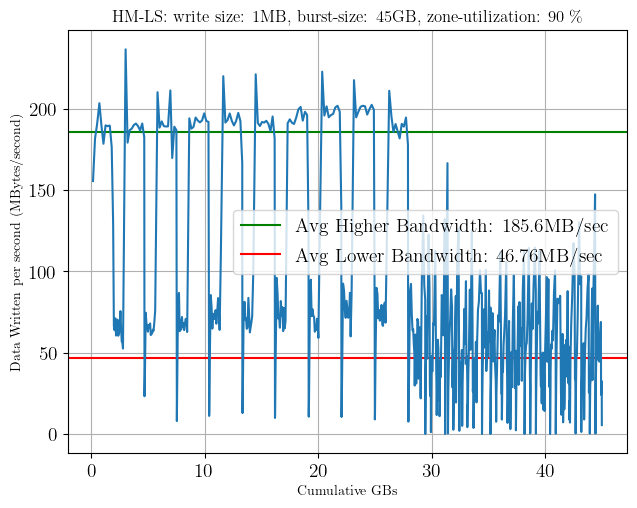

In [44]:
data_array = df_grouped['data_written_bytes'].values.reshape(-1, 1)
kmeans = KMeans(n_clusters=2)
kmeans.fit(data_array)
# Get the cluster centers
cluster_centers = kmeans.cluster_centers_.flatten()
# Sort cluster centers to get the lowest and highest modes
cluster_centers.sort()
# Calculate the average of each mode
average_mode1 = cluster_centers[0]
average_mode2 = cluster_centers[1]
print("Average1: " + str(round(average_mode1, )))
print("Average2: " + str(round(average_mode2, )))
avg_bw_str1 = str(round(average_mode1, 2)) + 'MB/sec'
avg_bw_str2 = str(round(average_mode2, 2)) + 'MB/sec'
fig, ax = plt.subplots()
plt.axhline(y=average_mode2, color='g', linestyle='-', label='Avg Higher Bandwidth: ' + avg_bw_str2)
plt.axhline(y=average_mode1, color='r', linestyle='-', label='Avg Lower Bandwidth: ' + avg_bw_str1)

# Plot vertical lines at x where y is higher than the threshold

#cid = plt.figure().canvas.mpl_connect('button_press_event', mouse_event)

plt.legend(loc='center right', fontsize=14)
# Plot the data size over time for each resolution
#plt.figure(figsize=(8, 6), dpi=80)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlim(0, 8000)
#plt.ylim(0, 250)
plt.tight_layout()
plt.plot(df_grouped['cumulative_gb'], df_grouped['data_written_bytes'])
#plt.plot(df_grouped.index, df_grouped['data_written_bytes'])
plt.xlabel('Cumulative GBs')
plt.ylabel('Data Written per second (MBytes/second)')
plt.grid(True)  # Optionally, add grid lines
plt.title("HM-LS: write size: 1MB, burst-size: 45GB, zone-utilization: 90 \%")
    
plt.savefig('/home/surbhi/github/surbhi-plots/new/LSDM/1M_90Util_9010_lsdm_CGBW.png', bbox_inches='tight')
plt.show()

The lowest power of 2 beyond which the plot won't go: 1.52587890625e-05, 0.0


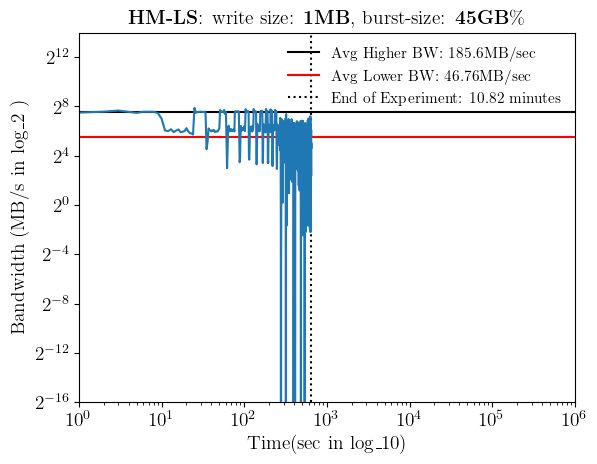

649


In [45]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.axhline(y=average_mode2, color='black', linestyle='-', label='Avg Higher BW: ' + avg_bw_str2)
plt.axhline(y=average_mode1, color='r', linestyle='-', label='Avg Lower BW: ' + avg_bw_str1)
plt.legend(loc='center right', fontsize=14)
#plt.plot(df_grouped.index, df_grouped['data_written_bytes'])

#plt.xlabel('Logarithmic (base 10) Time in seconds', fontsize=14)
#plt.ylabel('Logarithmic (base 2) Bandwidth (MB/sec)', fontsize=14)

plt.xlabel('Time(sec in log_{10})', fontsize=14)
plt.ylabel('Bandwidth (MB/s in log_2 )', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#plt.yticks(np.arange(0, 80, 10), fontsize=14)
plt.xscale('log', base=10)

common_yticks = [2**i for i in range(-16, 14, 2)]
plt.yticks(common_yticks)
ax = plt.gca()

# Custom formatter to display ticks as powers of 2
def log2_format(y, pos):
    return f'$2^{{{int(np.log2(y))}}}$' if y > 0 else '0'

# Find the minimum Y-value in the dataset
y_min = min(df_grouped['data_written_bytes'])
# Find the closest lower power of 2
#lowest_power_of_2 = 2 ** np.floor(np.log2(y_min))
lowest_power_of_2 = 2 ** -16
print(f"The lowest power of 2 beyond which the plot won't go: {lowest_power_of_2}, {y_min}")
# Set Y-axis limits to include the full range of ticks
# Set Y-axis limits
ax.set_ylim(lowest_power_of_2 , 2**14)
#ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(log2_format))
plt.yscale('log', base=2)
# Set the same number of ticks for all plots

# Custom formatter to display ticks as powers of 10
def log10_format(y, pos):
    return f'$10^{{{int(np.log10(y))}}}$' if y > 0 else '0'

common_ticks = [10**0, 10**1, 10**2, 10**3, 10**4, 10**5, 10**6]
ax.get_xaxis().set_major_formatter(ticker.FuncFormatter(log10_format))
ax.set_xlim(10**0, 10**5)
plt.xticks(common_ticks)

#plt.yscale('log', base=10)
#plt.yticks(np.arange(0, 300, 50), fontsize=14)
#plt.xticks(np.arange(0, 8000, 1000), fontsize=14)
#plt.grid(True)  # Optionally, add grid lines

xmax = df_grouped.index.max()
# Add a vertical line at the end of the experiment
xmin = round(int(xmax)/60, 2)
ax.axvline(x=xmax, color='black', linestyle=':', label='End of Experiment: ' + str(xmin) + ' minutes')
plt.legend(loc='upper right', fontsize=11, frameon=False)

plt.plot(df_grouped.index, df_grouped['data_written_bytes'])
plt.title(r"$\textbf{HM-LS}$: write size: $\textbf{1MB}$, burst-size: $\textbf{45GB}$\%",fontsize=14)    
plt.savefig('/home/surbhi/github/surbhi-plots/new/LSDM/1M_90Util_lsdm_BW.pdf', bbox_inches='tight', format="pdf")
plt.savefig('/home/surbhi/Downloads/1M_90Util_9010_lsdm_BW.pdf', bbox_inches='tight', format="pdf")
plt.show()
print(str(df_grouped.index[-1]))

0.6717711335000001
7.633285436


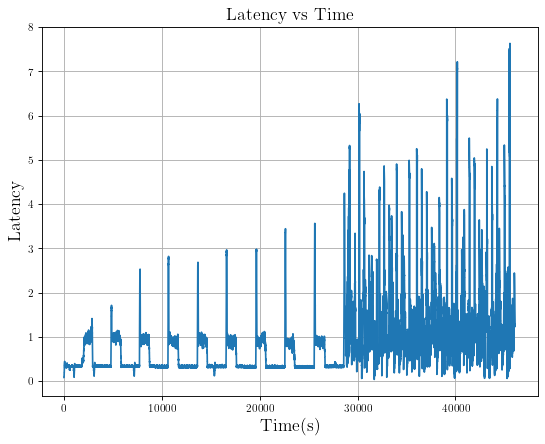

In [46]:
df = pd.read_csv('/home/surbhi/measurements/worst_case/lsdm/lsdm-util/90Util/1MB/8TB/90-10-LBA/45GB/lat_log_avg_lat.1.log', names=names_latency)
df['duration'] = df['duration']/1e9 #convert ns to seconds

# Plot the data
# Create the line plot
plt.figure(figsize=(8, 6), dpi=80)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.grid(True)  # Optionally, add grid lines
plt.plot(df.index, df['duration'])

# Add labels and title
plt.xlabel('Time(s)', fontsize=16)

plt.ylabel('Latency', fontsize=16)
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.title('Latency vs Time', fontsize=16)
#df.describe()
print(str(df['duration'].median()))
print(str(df['duration'].max()))

/tmp/ipykernel_19172/2872229170.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[44109.08916222 44109.08916222 44109.08916222 44109.08916222
 44109.08916222 44109.08916222 44109.08916222 44109.08916222
 44109.08916222 44109.08916222 44109.08916222 44109.08916222
 44109.08916222 44109.08916222 44109.08916222 44109.08916222
 44109.08916222 44109.08916222 44109.08916222 44109.08916222
 44109.08916222 44109.08916222 44109.08916222]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_written_ms.loc[start:end-1] += write_rate_per_ms


46079
Min Idx: 
530
Average1: 8
Average2: 53


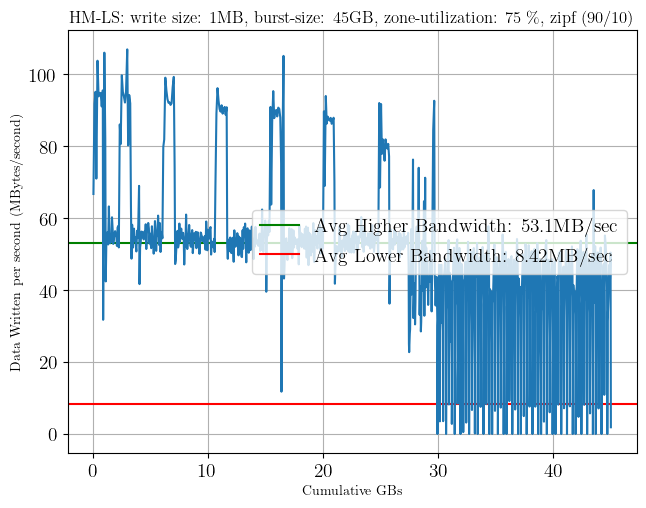

The lowest power of 2 beyond which the plot won't go: 1.52587890625e-05, 0.0


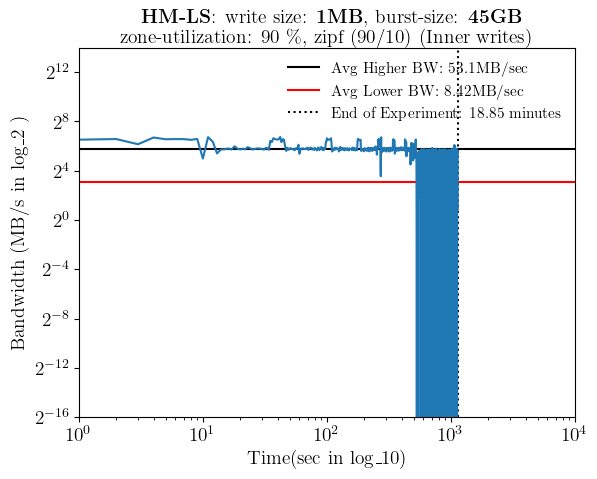

1131


In [47]:
names_latency=['submission_time', 'duration', 'op2', 'write_size', 'op3']
columns = ['submission_time', 'duration', 'write_size']

# Step 1: Read the CSV file into a Pandas DataFrame
df = pd.read_csv('/home/surbhi/measurements/worst_case/lsdm/lsdm-util/90Util/1MB/8TB/90-10-LBA/45GB.old/lat_log_avg_lat.1.log', names=names_latency, usecols=columns)

df['submission_time'] = np.floor(df['submission_time'] - df.iloc[0].submission_time)
df['duration'] = df['duration']/1e6 #convert ns to ms
df['completion_time'] = np.floor(df['submission_time'] + df['duration'])

# Step 3: Determine the start and end time of the entire test
start_time = int(df['submission_time'].min())
end_time = int(df['completion_time'].max())


# Step 4: Create new DataFrames to represent each  millisecond between the start and end time of the entire test
data_written_ms = pd.DataFrame(index=range(start_time, end_time + 1, 1), columns=['data_written_bytes'])
data_written_ms['data_written_bytes'] = 0

# Step 5: Iterate through each write request, calculate the data size for each time interval, and update the corresponding entries in the DataFrames
for index, row in df.iterrows():
    duration = row['duration']
    start = int(row['submission_time'])
    end = start+math.floor(duration)
    
    payload = (1024 * 1024)
    write_rate_per_ms = payload / max(duration, 1.)
    assert(write_rate_per_ms <= payload)
    residue = payload - write_rate_per_ms * math.floor(duration)
    assert (payload >= (write_rate_per_ms * math.floor(duration)))
    data_written_ms.loc[start:end-1] += write_rate_per_ms
    # residue could be zero when last == end
    data_written_ms.loc[end] += residue

print(index)
data_written_ms.reset_index(drop=True, inplace=True)

chunk_size = 10000
results = []
for i in range(0, len(data_written_ms), chunk_size):
    chunk = data_written_ms.iloc[i:i+chunk_size]
    result = chunk.groupby(custom_grouping).sum()
    results.append(result)

df_grouped = pd.concat(results)

# Reset the index to make it a regular column
df_grouped.reset_index(inplace=True)
df_grouped['cumulative_gb'] = df_grouped['data_written_bytes'].cumsum() / (1024 ** 3)
df_grouped['data_written_bytes'] = df_grouped['data_written_bytes'] / (1024 ** 2) 
#
#data_array = df_grouped['data_written_bytes'].values.reshape(-1, 1)
#print(df_grouped.describe())
#print(df_grouped.info())
print("Min Idx: \n" + str(df_grouped['data_written_bytes'].idxmin()))

data_array = df_grouped['data_written_bytes'].values.reshape(-1, 1)
kmeans = KMeans(n_clusters=2)
kmeans.fit(data_array)
# Get the cluster centers
cluster_centers = kmeans.cluster_centers_.flatten()
# Sort cluster centers to get the lowest and highest modes
cluster_centers.sort()
# Calculate the average of each mode
average_mode1 = cluster_centers[0]
average_mode2 = cluster_centers[1]
print("Average1: " + str(round(average_mode1, )))
print("Average2: " + str(round(average_mode2, )))
avg_bw_str1 = str(round(average_mode1, 2)) + 'MB/sec'
avg_bw_str2 = str(round(average_mode2, 2)) + 'MB/sec'
fig, ax = plt.subplots()
plt.axhline(y=average_mode2, color='g', linestyle='-', label='Avg Higher Bandwidth: ' + avg_bw_str2)
plt.axhline(y=average_mode1, color='r', linestyle='-', label='Avg Lower Bandwidth: ' + avg_bw_str1)

# Plot vertical lines at x where y is higher than the threshold

#cid = plt.figure().canvas.mpl_connect('button_press_event', mouse_event)

plt.legend(loc='center right', fontsize=14)
# Plot the data size over time for each resolution
#plt.figure(figsize=(8, 6), dpi=80)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlim(0, 8000)
#plt.ylim(0, 250)
plt.tight_layout()
plt.plot(df_grouped['cumulative_gb'], df_grouped['data_written_bytes'])
#plt.plot(df_grouped.index, df_grouped['data_written_bytes'])
plt.xlabel('Cumulative GBs')
plt.ylabel('Data Written per second (MBytes/second)')
plt.grid(True)  # Optionally, add grid lines
plt.title("HM-LS: write size: 1MB, burst-size: 45GB, zone-utilization: 75 \%, zipf (90/10)")
    
plt.savefig('/home/surbhi/github/surbhi-plots/new/LSDM/1M_75Util_HMLS_CGBW.png', bbox_inches='tight')
plt.show()

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.axhline(y=average_mode2, color='black', linestyle='-', label='Avg Higher BW: ' + avg_bw_str2)
plt.axhline(y=average_mode1, color='r', linestyle='-', label='Avg Lower BW: ' + avg_bw_str1)
plt.legend(loc='center right', fontsize=14)
#plt.plot(df_grouped.index, df_grouped['data_written_bytes'])

#plt.xlabel('Logarithmic (base 10) Time in seconds', fontsize=14)
#plt.ylabel('Logarithmic (base 2) Bandwidth (MB/sec)', fontsize=14)

plt.xlabel('Time(sec in log_{10})', fontsize=14)
plt.ylabel('Bandwidth (MB/s in log_2 )', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#plt.yticks(np.arange(0, 80, 10), fontsize=14)
plt.xscale('log', base=10)

common_yticks = [2**i for i in range(-16, 14, 2)]
plt.yticks(common_yticks)
ax = plt.gca()

# Custom formatter to display ticks as powers of 2
def log2_format(y, pos):
    return f'$2^{{{int(np.log2(y))}}}$' if y > 0 else '0'

# Find the minimum Y-value in the dataset
y_min = min(df_grouped['data_written_bytes'])
# Find the closest lower power of 2
#lowest_power_of_2 = 2 ** np.floor(np.log2(y_min))
lowest_power_of_2 = 2 ** -16
print(f"The lowest power of 2 beyond which the plot won't go: {lowest_power_of_2}, {y_min}")
# Set Y-axis limits to include the full range of ticks
# Set Y-axis limits
ax.set_ylim(lowest_power_of_2 , 2**14)
#ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(log2_format))
plt.yscale('log', base=2)
# Set the same number of ticks for all plots

# Custom formatter to display ticks as powers of 10
def log10_format(y, pos):
    return f'$10^{{{int(np.log10(y))}}}$' if y > 0 else '0'

common_ticks = [10**0, 10**1, 10**2, 10**3, 10**4]
ax.get_xaxis().set_major_formatter(ticker.FuncFormatter(log10_format))
ax.set_xlim(10**0, 10**4)
plt.xticks(common_ticks)

#plt.yscale('log', base=10)
#plt.yticks(np.arange(0, 300, 50), fontsize=14)
#plt.xticks(np.arange(0, 8000, 1000), fontsize=14)
#plt.grid(True)  # Optionally, add grid lines

xmax = df_grouped.index.max()
# Add a vertical line at the end of the experiment
xmin = round(int(xmax)/60, 2)
ax.axvline(x=xmax, color='black', linestyle=':', label='End of Experiment: ' + str(xmin) + ' minutes')
plt.legend(loc='upper right', fontsize=11, frameon=False)

plt.plot(df_grouped.index, df_grouped['data_written_bytes'])
plt.title(r"$\textbf{HM-LS}$: write size: $\textbf{1MB}$, burst-size: $\textbf{45GB}$ \\ zone-utilization: 90 \%, zipf (90/10) (Inner writes)",fontsize=14)    
plt.savefig('/home/surbhi/github/surbhi-plots/new/LSDM/1M_90Util_Inner_90_10_lsdm_BW.pdf', bbox_inches='tight', format="pdf")
#plt.savefig('/home/surbhi/Downloads/1M_90Util90_10_LSDM_Inner_BW.pdf', bbox_inches='tight', format="pdf")
plt.savefig('/home/surbhi/Downloads/1M_90Util90_10_HMLS_Inner_BW.jpeg', bbox_inches='tight')
plt.show()
print(str(df_grouped.index[-1]))

/tmp/ipykernel_19172/3646594647.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[52653.6124966 52653.6124966 52653.6124966 52653.6124966 52653.6124966
 52653.6124966 52653.6124966 52653.6124966 52653.6124966 52653.6124966
 52653.6124966 52653.6124966 52653.6124966 52653.6124966 52653.6124966
 52653.6124966 52653.6124966 52653.6124966 52653.6124966]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_written_ms.loc[start:end-1] += write_rate_per_ms


46079
Min Idx: 
530
Average1: 9
Average2: 53


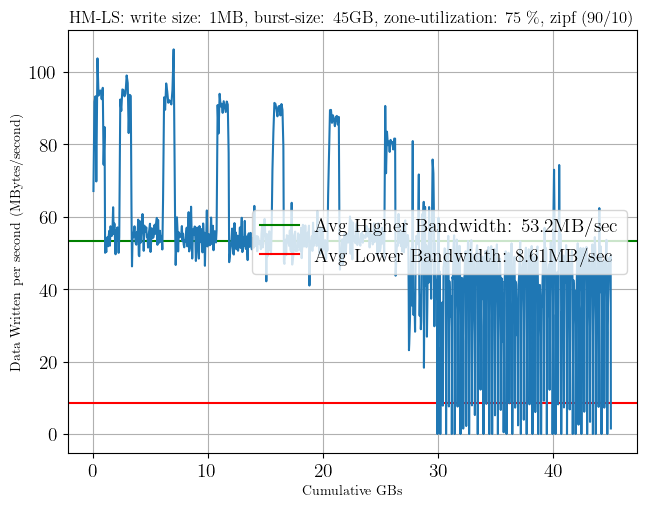

The lowest power of 2 beyond which the plot won't go: 1.52587890625e-05, 0.0


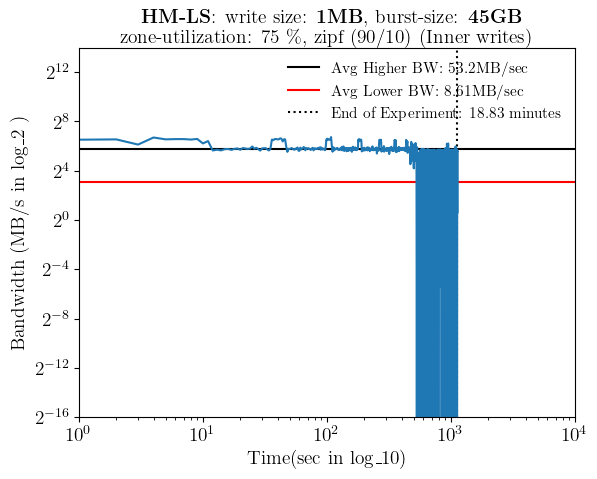

1130


In [48]:
names_latency=['submission_time', 'duration', 'op2', 'write_size', 'op3']
columns = ['submission_time', 'duration', 'write_size']

# Step 1: Read the CSV file into a Pandas DataFrame
df = pd.read_csv('/home/surbhi/measurements/worst_case/lsdm/lsdm-util/75Util/1MB/8TB/90-10-LBA/45GB/lat_log_avg_lat.1.log', names=names_latency, usecols=columns)

df['submission_time'] = np.floor(df['submission_time'] - df.iloc[0].submission_time)
df['duration'] = df['duration']/1e6 #convert ns to ms
df['completion_time'] = np.floor(df['submission_time'] + df['duration'])

# Step 3: Determine the start and end time of the entire test
start_time = int(df['submission_time'].min())
end_time = int(df['completion_time'].max())


# Step 4: Create new DataFrames to represent each  millisecond between the start and end time of the entire test
data_written_ms = pd.DataFrame(index=range(start_time, end_time + 1, 1), columns=['data_written_bytes'])
data_written_ms['data_written_bytes'] = 0

# Step 5: Iterate through each write request, calculate the data size for each time interval, and update the corresponding entries in the DataFrames
for index, row in df.iterrows():
    duration = row['duration']
    start = int(row['submission_time'])
    end = start+math.floor(duration)
    
    payload = (1024 * 1024)
    write_rate_per_ms = payload / max(duration, 1.)
    assert(write_rate_per_ms <= payload)
    residue = payload - write_rate_per_ms * math.floor(duration)
    assert (payload >= (write_rate_per_ms * math.floor(duration)))
    data_written_ms.loc[start:end-1] += write_rate_per_ms
    # residue could be zero when last == end
    data_written_ms.loc[end] += residue

print(index)
data_written_ms.reset_index(drop=True, inplace=True)

chunk_size = 10000
results = []
for i in range(0, len(data_written_ms), chunk_size):
    chunk = data_written_ms.iloc[i:i+chunk_size]
    result = chunk.groupby(custom_grouping).sum()
    results.append(result)

df_grouped = pd.concat(results)

# Reset the index to make it a regular column
df_grouped.reset_index(inplace=True)
df_grouped['cumulative_gb'] = df_grouped['data_written_bytes'].cumsum() / (1024 ** 3)
df_grouped['data_written_bytes'] = df_grouped['data_written_bytes'] / (1024 ** 2) 
#
#data_array = df_grouped['data_written_bytes'].values.reshape(-1, 1)
#print(df_grouped.describe())
#print(df_grouped.info())
print("Min Idx: \n" + str(df_grouped['data_written_bytes'].idxmin()))

data_array = df_grouped['data_written_bytes'].values.reshape(-1, 1)
kmeans = KMeans(n_clusters=2)
kmeans.fit(data_array)
# Get the cluster centers
cluster_centers = kmeans.cluster_centers_.flatten()
# Sort cluster centers to get the lowest and highest modes
cluster_centers.sort()
# Calculate the average of each mode
average_mode1 = cluster_centers[0]
average_mode2 = cluster_centers[1]
print("Average1: " + str(round(average_mode1, )))
print("Average2: " + str(round(average_mode2, )))
avg_bw_str1 = str(round(average_mode1, 2)) + 'MB/sec'
avg_bw_str2 = str(round(average_mode2, 2)) + 'MB/sec'
fig, ax = plt.subplots()
plt.axhline(y=average_mode2, color='g', linestyle='-', label='Avg Higher Bandwidth: ' + avg_bw_str2)
plt.axhline(y=average_mode1, color='r', linestyle='-', label='Avg Lower Bandwidth: ' + avg_bw_str1)

# Plot vertical lines at x where y is higher than the threshold

#cid = plt.figure().canvas.mpl_connect('button_press_event', mouse_event)

plt.legend(loc='center right', fontsize=14)
# Plot the data size over time for each resolution
#plt.figure(figsize=(8, 6), dpi=80)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlim(0, 8000)
#plt.ylim(0, 250)
plt.tight_layout()
plt.plot(df_grouped['cumulative_gb'], df_grouped['data_written_bytes'])
#plt.plot(df_grouped.index, df_grouped['data_written_bytes'])
plt.xlabel('Cumulative GBs')
plt.ylabel('Data Written per second (MBytes/second)')
plt.grid(True)  # Optionally, add grid lines
plt.title("HM-LS: write size: 1MB, burst-size: 45GB, zone-utilization: 75 \%, zipf (90/10)")
    
plt.savefig('/home/surbhi/github/surbhi-plots/new/LSDM/1M_75Util_HMLS_CGBW.png', bbox_inches='tight')
plt.show()

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.axhline(y=average_mode2, color='black', linestyle='-', label='Avg Higher BW: ' + avg_bw_str2)
plt.axhline(y=average_mode1, color='r', linestyle='-', label='Avg Lower BW: ' + avg_bw_str1)
plt.legend(loc='center right', fontsize=14)
#plt.plot(df_grouped.index, df_grouped['data_written_bytes'])

#plt.xlabel('Logarithmic (base 10) Time in seconds', fontsize=14)
#plt.ylabel('Logarithmic (base 2) Bandwidth (MB/sec)', fontsize=14)

plt.xlabel('Time(sec in log_{10})', fontsize=14)
plt.ylabel('Bandwidth (MB/s in log_2 )', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#plt.yticks(np.arange(0, 80, 10), fontsize=14)
plt.xscale('log', base=10)

common_yticks = [2**i for i in range(-16, 14, 2)]
plt.yticks(common_yticks)
ax = plt.gca()

# Custom formatter to display ticks as powers of 2
def log2_format(y, pos):
    return f'$2^{{{int(np.log2(y))}}}$' if y > 0 else '0'

# Find the minimum Y-value in the dataset
y_min = min(df_grouped['data_written_bytes'])
# Find the closest lower power of 2
#lowest_power_of_2 = 2 ** np.floor(np.log2(y_min))
lowest_power_of_2 = 2 ** -16
print(f"The lowest power of 2 beyond which the plot won't go: {lowest_power_of_2}, {y_min}")
# Set Y-axis limits to include the full range of ticks
# Set Y-axis limits
ax.set_ylim(lowest_power_of_2 , 2**14)
#ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(log2_format))
plt.yscale('log', base=2)
# Set the same number of ticks for all plots

# Custom formatter to display ticks as powers of 10
def log10_format(y, pos):
    return f'$10^{{{int(np.log10(y))}}}$' if y > 0 else '0'

common_ticks = [10**0, 10**1, 10**2, 10**3, 10**4]
ax.get_xaxis().set_major_formatter(ticker.FuncFormatter(log10_format))
ax.set_xlim(10**0, 10**4)
plt.xticks(common_ticks)

#plt.yscale('log', base=10)
#plt.yticks(np.arange(0, 300, 50), fontsize=14)
#plt.xticks(np.arange(0, 8000, 1000), fontsize=14)
#plt.grid(True)  # Optionally, add grid lines

xmax = df_grouped.index.max()
# Add a vertical line at the end of the experiment
xmin = round(int(xmax)/60, 2)
ax.axvline(x=xmax, color='black', linestyle=':', label='End of Experiment: ' + str(xmin) + ' minutes')
plt.legend(loc='upper right', fontsize=11, frameon=False)

plt.plot(df_grouped.index, df_grouped['data_written_bytes'])
plt.title(r"$\textbf{HM-LS}$: write size: $\textbf{1MB}$, burst-size: $\textbf{45GB}$ \\ zone-utilization: 75 \%, zipf (90/10) (Inner writes)",fontsize=14)    
plt.savefig('/home/surbhi/github/surbhi-plots/new/LSDM/1M_75Util90_10_lsdm_BW.pdf', bbox_inches='tight', format="pdf")
#plt.savefig('/home/surbhi/Downloads/1M_90Util90_10_LSDM_BW.pdf', bbox_inches='tight', format="pdf")
plt.savefig('/home/surbhi/Downloads/1M_75Util90_10_HMLS_Inner_BW.jpeg', bbox_inches='tight')
plt.show()
print(str(df_grouped.index[-1]))

/tmp/ipykernel_19172/629503918.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[46489.8536875 46489.8536875 46489.8536875 46489.8536875 46489.8536875
 46489.8536875 46489.8536875 46489.8536875 46489.8536875 46489.8536875
 46489.8536875 46489.8536875 46489.8536875 46489.8536875 46489.8536875
 46489.8536875 46489.8536875 46489.8536875 46489.8536875 46489.8536875
 46489.8536875 46489.8536875]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_written_ms.loc[start:end-1] += write_rate_per_ms


46079
Min Idx: 
575
Average1: 7
Average2: 50


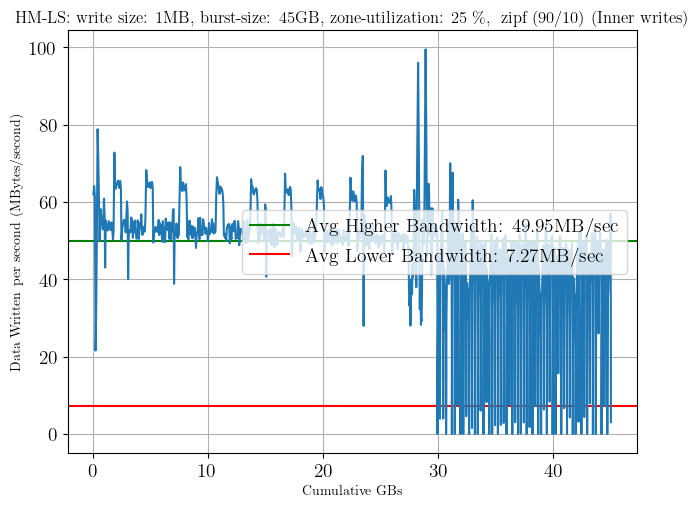

The lowest power of 2 beyond which the plot won't go: 1.52587890625e-05, 0.0


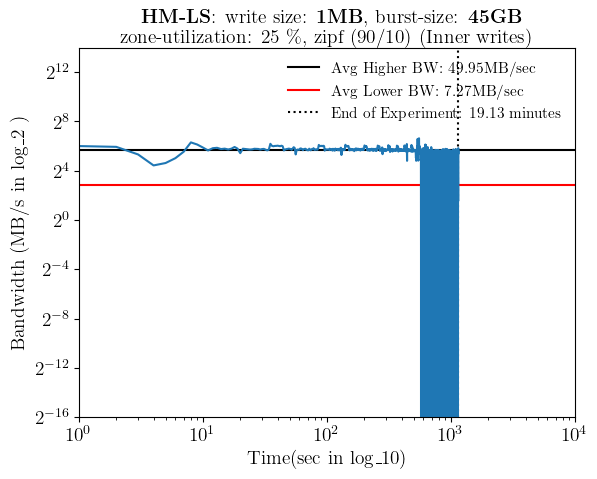

1148


In [49]:
names_latency=['submission_time', 'duration', 'op2', 'write_size', 'op3']
columns = ['submission_time', 'duration', 'write_size']

# Step 1: Read the CSV file into a Pandas DataFrame
df = pd.read_csv('/home/surbhi/measurements/worst_case/lsdm/lsdm-util/25Util/1MB/8TB/90-10-LBA/45GB/lat_log_avg_lat.1.log', names=names_latency, usecols=columns)

df['submission_time'] = np.floor(df['submission_time'] - df.iloc[0].submission_time)
df['duration'] = df['duration']/1e6 #convert ns to ms
df['completion_time'] = np.floor(df['submission_time'] + df['duration'])

# Step 3: Determine the start and end time of the entire test
start_time = int(df['submission_time'].min())
end_time = int(df['completion_time'].max())


# Step 4: Create new DataFrames to represent each  millisecond between the start and end time of the entire test
data_written_ms = pd.DataFrame(index=range(start_time, end_time + 1, 1), columns=['data_written_bytes'])
data_written_ms['data_written_bytes'] = 0

# Step 5: Iterate through each write request, calculate the data size for each time interval, and update the corresponding entries in the DataFrames
for index, row in df.iterrows():
    duration = row['duration']
    start = int(row['submission_time'])
    end = start+math.floor(duration)
    
    payload = (1024 * 1024)
    write_rate_per_ms = payload / max(duration, 1.)
    assert(write_rate_per_ms <= payload)
    residue = payload - write_rate_per_ms * math.floor(duration)
    assert (payload >= (write_rate_per_ms * math.floor(duration)))
    data_written_ms.loc[start:end-1] += write_rate_per_ms
    # residue could be zero when last == end
    data_written_ms.loc[end] += residue

print(index)
data_written_ms.reset_index(drop=True, inplace=True)

chunk_size = 10000
results = []
for i in range(0, len(data_written_ms), chunk_size):
    chunk = data_written_ms.iloc[i:i+chunk_size]
    result = chunk.groupby(custom_grouping).sum()
    results.append(result)

df_grouped = pd.concat(results)

# Reset the index to make it a regular column
df_grouped.reset_index(inplace=True)
df_grouped['cumulative_gb'] = df_grouped['data_written_bytes'].cumsum() / (1024 ** 3)
df_grouped['data_written_bytes'] = df_grouped['data_written_bytes'] / (1024 ** 2) 
#
#data_array = df_grouped['data_written_bytes'].values.reshape(-1, 1)
#print(df_grouped.describe())
#print(df_grouped.info())
print("Min Idx: \n" + str(df_grouped['data_written_bytes'].idxmin()))

data_array = df_grouped['data_written_bytes'].values.reshape(-1, 1)
kmeans = KMeans(n_clusters=2)
kmeans.fit(data_array)
# Get the cluster centers
cluster_centers = kmeans.cluster_centers_.flatten()
# Sort cluster centers to get the lowest and highest modes
cluster_centers.sort()
# Calculate the average of each mode
average_mode1 = cluster_centers[0]
average_mode2 = cluster_centers[1]
print("Average1: " + str(round(average_mode1, )))
print("Average2: " + str(round(average_mode2, )))
avg_bw_str1 = str(round(average_mode1, 2)) + 'MB/sec'
avg_bw_str2 = str(round(average_mode2, 2)) + 'MB/sec'
fig, ax = plt.subplots()
plt.axhline(y=average_mode2, color='g', linestyle='-', label='Avg Higher Bandwidth: ' + avg_bw_str2)
plt.axhline(y=average_mode1, color='r', linestyle='-', label='Avg Lower Bandwidth: ' + avg_bw_str1)

# Plot vertical lines at x where y is higher than the threshold

#cid = plt.figure().canvas.mpl_connect('button_press_event', mouse_event)

plt.legend(loc='center right', fontsize=14)
# Plot the data size over time for each resolution
#plt.figure(figsize=(8, 6), dpi=80)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlim(0, 8000)
#plt.ylim(0, 250)
plt.tight_layout()
plt.plot(df_grouped['cumulative_gb'], df_grouped['data_written_bytes'])
#plt.plot(df_grouped.index, df_grouped['data_written_bytes'])
plt.xlabel('Cumulative GBs')
plt.ylabel('Data Written per second (MBytes/second)')
plt.grid(True)  # Optionally, add grid lines
plt.title("HM-LS: write size: 1MB, burst-size: 45GB, zone-utilization: 25 \%, \\ zipf (90/10) (Inner writes)")
    
plt.savefig('/home/surbhi/github/surbhi-plots/new/LSDM/1M_25Util_HMLS_Inner_CGBW.png', bbox_inches='tight')
plt.show()

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.axhline(y=average_mode2, color='black', linestyle='-', label='Avg Higher BW: ' + avg_bw_str2)
plt.axhline(y=average_mode1, color='r', linestyle='-', label='Avg Lower BW: ' + avg_bw_str1)
plt.legend(loc='center right', fontsize=14)
#plt.plot(df_grouped.index, df_grouped['data_written_bytes'])

#plt.xlabel('Logarithmic (base 10) Time in seconds', fontsize=14)
#plt.ylabel('Logarithmic (base 2) Bandwidth (MB/sec)', fontsize=14)

plt.xlabel('Time(sec in log_{10})', fontsize=14)
plt.ylabel('Bandwidth (MB/s in log_2 )', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#plt.yticks(np.arange(0, 80, 10), fontsize=14)
plt.xscale('log', base=10)

common_yticks = [2**i for i in range(-16, 14, 2)]
plt.yticks(common_yticks)
ax = plt.gca()

# Custom formatter to display ticks as powers of 2
def log2_format(y, pos):
    return f'$2^{{{int(np.log2(y))}}}$' if y > 0 else '0'

# Find the minimum Y-value in the dataset
y_min = min(df_grouped['data_written_bytes'])
# Find the closest lower power of 2
#lowest_power_of_2 = 2 ** np.floor(np.log2(y_min))
lowest_power_of_2 = 2 ** -16
print(f"The lowest power of 2 beyond which the plot won't go: {lowest_power_of_2}, {y_min}")
# Set Y-axis limits to include the full range of ticks
# Set Y-axis limits
ax.set_ylim(lowest_power_of_2 , 2**14)
#ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(log2_format))
plt.yscale('log', base=2)
# Set the same number of ticks for all plots

# Custom formatter to display ticks as powers of 10
def log10_format(y, pos):
    return f'$10^{{{int(np.log10(y))}}}$' if y > 0 else '0'

common_ticks = [10**0, 10**1, 10**2, 10**3, 10**4]
ax.get_xaxis().set_major_formatter(ticker.FuncFormatter(log10_format))
ax.set_xlim(10**0, 10**4)
plt.xticks(common_ticks)

#plt.yscale('log', base=10)
#plt.yticks(np.arange(0, 300, 50), fontsize=14)
#plt.xticks(np.arange(0, 8000, 1000), fontsize=14)
#plt.grid(True)  # Optionally, add grid lines

xmax = df_grouped.index.max()
# Add a vertical line at the end of the experiment
xmin = round(int(xmax)/60, 2)
ax.axvline(x=xmax, color='black', linestyle=':', label='End of Experiment: ' + str(xmin) + ' minutes')
plt.legend(loc='upper right', fontsize=11, frameon=False)

plt.plot(df_grouped.index, df_grouped['data_written_bytes'])
plt.title(r"$\textbf{HM-LS}$: write size: $\textbf{1MB}$, burst-size: $\textbf{45GB}$ \\ zone-utilization: 25 \%, zipf (90/10) (Inner writes)",fontsize=14)    
plt.savefig('/home/surbhi/github/surbhi-plots/new/LSDM/1M_25Util90_10_lsdm_Inner_BW.pdf', bbox_inches='tight', format="pdf")
#plt.savefig('/home/surbhi/Downloads/1M_90UtilUniform_LSDM_Inner_BW.pdf', bbox_inches='tight', format="pdf")
plt.savefig('/home/surbhi/Downloads/1M_25Util90_10_HMLS_Inner_BW.jpeg', bbox_inches='tight')
plt.show()
print(str(df_grouped.index[-1]))

/tmp/ipykernel_19172/3814115395.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[466.97688305 466.97688305 466.97688305 ... 466.97688305 466.97688305
 466.97688305]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_written_ms.loc[start:end-1] += write_rate_per_ms


5119
Min Idx: 
7
Average1: 14
Average2: 103


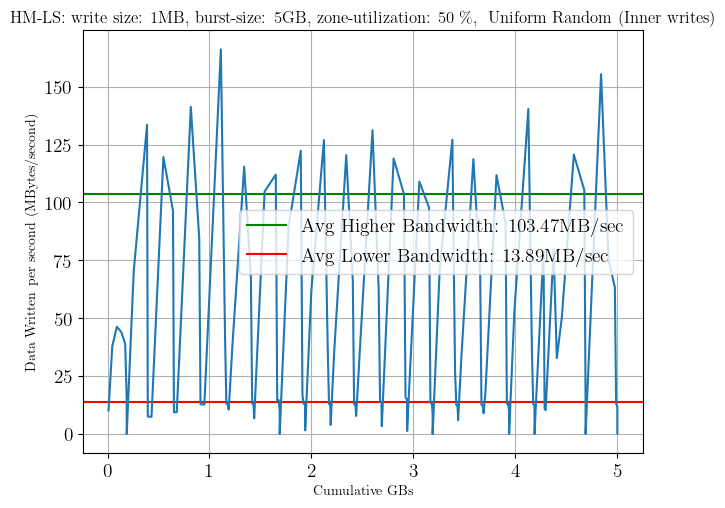

The lowest power of 2 beyond which the plot won't go: 1.52587890625e-05, 0.0


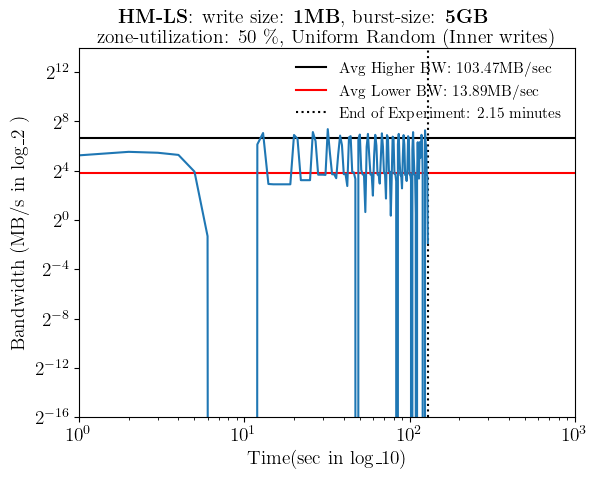

129


In [50]:
names_latency=['submission_time', 'duration', 'op2', 'write_size', 'op3']
columns = ['submission_time', 'duration', 'write_size']

# Step 1: Read the CSV file into a Pandas DataFrame
df = pd.read_csv('/home/surbhi/measurements/worst_case/lsdm/lsdm-util/50Util/1MB/8TB/uniform/lat_log_avg_lat.1.log', names=names_latency, usecols=columns)

df['submission_time'] = np.floor(df['submission_time'] - df.iloc[0].submission_time)
df['duration'] = df['duration']/1e6 #convert ns to ms
df['completion_time'] = np.floor(df['submission_time'] + df['duration'])

# Step 3: Determine the start and end time of the entire test
start_time = int(df['submission_time'].min())
end_time = int(df['completion_time'].max())


# Step 4: Create new DataFrames to represent each  millisecond between the start and end time of the entire test
data_written_ms = pd.DataFrame(index=range(start_time, end_time + 1, 1), columns=['data_written_bytes'])
data_written_ms['data_written_bytes'] = 0

# Step 5: Iterate through each write request, calculate the data size for each time interval, and update the corresponding entries in the DataFrames
for index, row in df.iterrows():
    duration = row['duration']
    start = int(row['submission_time'])
    end = start+math.floor(duration)
    
    payload = (1024 * 1024)
    write_rate_per_ms = payload / max(duration, 1.)
    assert(write_rate_per_ms <= payload)
    residue = payload - write_rate_per_ms * math.floor(duration)
    assert (payload >= (write_rate_per_ms * math.floor(duration)))
    data_written_ms.loc[start:end-1] += write_rate_per_ms
    # residue could be zero when last == end
    data_written_ms.loc[end] += residue

print(index)
data_written_ms.reset_index(drop=True, inplace=True)

chunk_size = 10000
results = []
for i in range(0, len(data_written_ms), chunk_size):
    chunk = data_written_ms.iloc[i:i+chunk_size]
    result = chunk.groupby(custom_grouping).sum()
    results.append(result)

df_grouped = pd.concat(results)

# Reset the index to make it a regular column
df_grouped.reset_index(inplace=True)
df_grouped['cumulative_gb'] = df_grouped['data_written_bytes'].cumsum() / (1024 ** 3)
df_grouped['data_written_bytes'] = df_grouped['data_written_bytes'] / (1024 ** 2) 
#
#data_array = df_grouped['data_written_bytes'].values.reshape(-1, 1)
#print(df_grouped.describe())
#print(df_grouped.info())
print("Min Idx: \n" + str(df_grouped['data_written_bytes'].idxmin()))

data_array = df_grouped['data_written_bytes'].values.reshape(-1, 1)
kmeans = KMeans(n_clusters=2)
kmeans.fit(data_array)
# Get the cluster centers
cluster_centers = kmeans.cluster_centers_.flatten()
# Sort cluster centers to get the lowest and highest modes
cluster_centers.sort()
# Calculate the average of each mode
average_mode1 = cluster_centers[0]
average_mode2 = cluster_centers[1]
print("Average1: " + str(round(average_mode1, )))
print("Average2: " + str(round(average_mode2, )))
avg_bw_str1 = str(round(average_mode1, 2)) + 'MB/sec'
avg_bw_str2 = str(round(average_mode2, 2)) + 'MB/sec'
fig, ax = plt.subplots()
plt.axhline(y=average_mode2, color='g', linestyle='-', label='Avg Higher Bandwidth: ' + avg_bw_str2)
plt.axhline(y=average_mode1, color='r', linestyle='-', label='Avg Lower Bandwidth: ' + avg_bw_str1)

# Plot vertical lines at x where y is higher than the threshold

#cid = plt.figure().canvas.mpl_connect('button_press_event', mouse_event)

plt.legend(loc='center right', fontsize=14)
# Plot the data size over time for each resolution
#plt.figure(figsize=(8, 6), dpi=80)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlim(0, 8000)
#plt.ylim(0, 250)
plt.tight_layout()
plt.plot(df_grouped['cumulative_gb'], df_grouped['data_written_bytes'])
#plt.plot(df_grouped.index, df_grouped['data_written_bytes'])
plt.xlabel('Cumulative GBs')
plt.ylabel('Data Written per second (MBytes/second)')
plt.grid(True)  # Optionally, add grid lines
plt.title("HM-LS: write size: 1MB, burst-size: 5GB, zone-utilization: 50 \%, \\ Uniform Random (Inner writes)")
    
plt.savefig('/home/surbhi/github/surbhi-plots/new/LSDM/1M_50Util_Uniform_HMLS_Inner_CGBW.png', bbox_inches='tight')
plt.show()

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.axhline(y=average_mode2, color='black', linestyle='-', label='Avg Higher BW: ' + avg_bw_str2)
plt.axhline(y=average_mode1, color='r', linestyle='-', label='Avg Lower BW: ' + avg_bw_str1)
plt.legend(loc='center right', fontsize=14)
#plt.plot(df_grouped.index, df_grouped['data_written_bytes'])

#plt.xlabel('Logarithmic (base 10) Time in seconds', fontsize=14)
#plt.ylabel('Logarithmic (base 2) Bandwidth (MB/sec)', fontsize=14)

plt.xlabel('Time(sec in log_{10})', fontsize=14)
plt.ylabel('Bandwidth (MB/s in log_2 )', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#plt.yticks(np.arange(0, 80, 10), fontsize=14)
plt.xscale('log', base=10)

common_yticks = [2**i for i in range(-16, 14, 2)]
plt.yticks(common_yticks)
ax = plt.gca()

# Custom formatter to display ticks as powers of 2
def log2_format(y, pos):
    return f'$2^{{{int(np.log2(y))}}}$' if y > 0 else '0'

# Find the minimum Y-value in the dataset
y_min = min(df_grouped['data_written_bytes'])
# Find the closest lower power of 2
#lowest_power_of_2 = 2 ** np.floor(np.log2(y_min))
lowest_power_of_2 = 2 ** -16
print(f"The lowest power of 2 beyond which the plot won't go: {lowest_power_of_2}, {y_min}")
# Set Y-axis limits to include the full range of ticks
# Set Y-axis limits
ax.set_ylim(lowest_power_of_2 , 2**14)
#ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(log2_format))
plt.yscale('log', base=2)
# Set the same number of ticks for all plots

# Custom formatter to display ticks as powers of 10
def log10_format(y, pos):
    return f'$10^{{{int(np.log10(y))}}}$' if y > 0 else '0'

common_ticks = [10**0, 10**1, 10**2, 10**3]
ax.get_xaxis().set_major_formatter(ticker.FuncFormatter(log10_format))
ax.set_xlim(10**0, 10**3)
plt.xticks(common_ticks)

#plt.yscale('log', base=10)
#plt.yticks(np.arange(0, 300, 50), fontsize=14)
#plt.xticks(np.arange(0, 8000, 1000), fontsize=14)
#plt.grid(True)  # Optionally, add grid lines

xmax = df_grouped.index.max()
# Add a vertical line at the end of the experiment
xmin = round(int(xmax)/60, 2)
ax.axvline(x=xmax, color='black', linestyle=':', label='End of Experiment: ' + str(xmin) + ' minutes')
plt.legend(loc='upper right', fontsize=11, frameon=False)

plt.plot(df_grouped.index, df_grouped['data_written_bytes'])
plt.title(r"$\textbf{HM-LS}$: write size: $\textbf{1MB}$, burst-size: $\textbf{5GB}$ \\ zone-utilization: 50 \%, Uniform Random (Inner writes)",fontsize=14)    
#plt.savefig('/home/surbhi/github/surbhi-plots/new/LSDM/1M_25Util90_10_lsdm_Inner_BW.pdf', bbox_inches='tight', format="pdf")
#plt.savefig('/home/surbhi/Downloads/1M_90UtilUniform_LSDM_Inner_BW.pdf', bbox_inches='tight', format="pdf")
plt.savefig('/home/surbhi/Downloads/1M_25UtilUniform_HMLS_Inner_BW.jpeg', bbox_inches='tight')
plt.show()
print(str(df_grouped.index[-1]))

/tmp/ipykernel_19172/1235829750.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[226.85415412 226.85415412 226.85415412 ... 226.85415412 226.85415412
 226.85415412]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_written_ms.loc[start:end-1] += write_rate_per_ms


5119
Min Idx: 
8
Average1: 9
Average2: 107


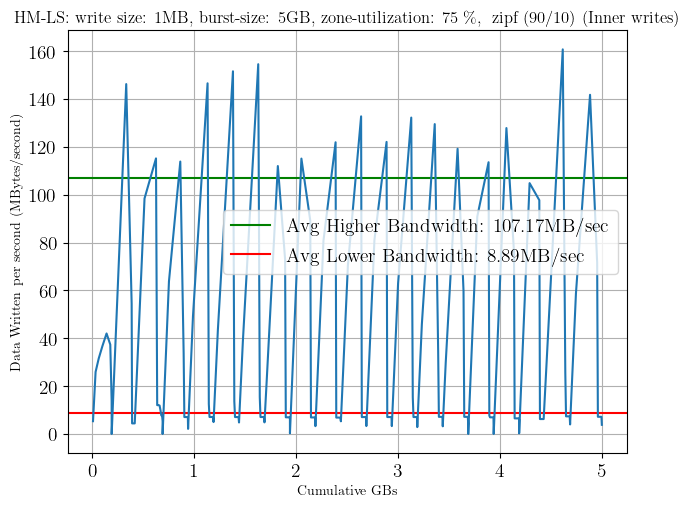

The lowest power of 2 beyond which the plot won't go: 1.52587890625e-05, 0.0


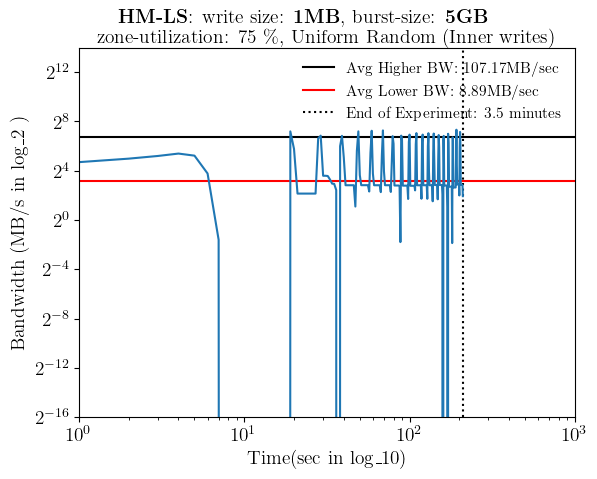

210


In [51]:
names_latency=['submission_time', 'duration', 'op2', 'write_size', 'op3']
columns = ['submission_time', 'duration', 'write_size']

# Step 1: Read the CSV file into a Pandas DataFrame
df = pd.read_csv('/home/surbhi/measurements/worst_case/lsdm/lsdm-util/75Util/1MB/8TB/uniform/lat_log_avg_lat.1.log', names=names_latency, usecols=columns)

df['submission_time'] = np.floor(df['submission_time'] - df.iloc[0].submission_time)
df['duration'] = df['duration']/1e6 #convert ns to ms
df['completion_time'] = np.floor(df['submission_time'] + df['duration'])

# Step 3: Determine the start and end time of the entire test
start_time = int(df['submission_time'].min())
end_time = int(df['completion_time'].max())


# Step 4: Create new DataFrames to represent each  millisecond between the start and end time of the entire test
data_written_ms = pd.DataFrame(index=range(start_time, end_time + 1, 1), columns=['data_written_bytes'])
data_written_ms['data_written_bytes'] = 0

# Step 5: Iterate through each write request, calculate the data size for each time interval, and update the corresponding entries in the DataFrames
for index, row in df.iterrows():
    duration = row['duration']
    start = int(row['submission_time'])
    end = start+math.floor(duration)
    
    payload = (1024 * 1024)
    write_rate_per_ms = payload / max(duration, 1.)
    assert(write_rate_per_ms <= payload)
    residue = payload - write_rate_per_ms * math.floor(duration)
    assert (payload >= (write_rate_per_ms * math.floor(duration)))
    data_written_ms.loc[start:end-1] += write_rate_per_ms
    # residue could be zero when last == end
    data_written_ms.loc[end] += residue

print(index)
data_written_ms.reset_index(drop=True, inplace=True)

chunk_size = 10000
results = []
for i in range(0, len(data_written_ms), chunk_size):
    chunk = data_written_ms.iloc[i:i+chunk_size]
    result = chunk.groupby(custom_grouping).sum()
    results.append(result)

df_grouped = pd.concat(results)

# Reset the index to make it a regular column
df_grouped.reset_index(inplace=True)
df_grouped['cumulative_gb'] = df_grouped['data_written_bytes'].cumsum() / (1024 ** 3)
df_grouped['data_written_bytes'] = df_grouped['data_written_bytes'] / (1024 ** 2) 
#
#data_array = df_grouped['data_written_bytes'].values.reshape(-1, 1)
#print(df_grouped.describe())
#print(df_grouped.info())
print("Min Idx: \n" + str(df_grouped['data_written_bytes'].idxmin()))

data_array = df_grouped['data_written_bytes'].values.reshape(-1, 1)
kmeans = KMeans(n_clusters=2)
kmeans.fit(data_array)
# Get the cluster centers
cluster_centers = kmeans.cluster_centers_.flatten()
# Sort cluster centers to get the lowest and highest modes
cluster_centers.sort()
# Calculate the average of each mode
average_mode1 = cluster_centers[0]
average_mode2 = cluster_centers[1]
print("Average1: " + str(round(average_mode1, )))
print("Average2: " + str(round(average_mode2, )))
avg_bw_str1 = str(round(average_mode1, 2)) + 'MB/sec'
avg_bw_str2 = str(round(average_mode2, 2)) + 'MB/sec'
fig, ax = plt.subplots()
plt.axhline(y=average_mode2, color='g', linestyle='-', label='Avg Higher Bandwidth: ' + avg_bw_str2)
plt.axhline(y=average_mode1, color='r', linestyle='-', label='Avg Lower Bandwidth: ' + avg_bw_str1)

# Plot vertical lines at x where y is higher than the threshold

#cid = plt.figure().canvas.mpl_connect('button_press_event', mouse_event)

plt.legend(loc='center right', fontsize=14)
# Plot the data size over time for each resolution
#plt.figure(figsize=(8, 6), dpi=80)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlim(0, 8000)
#plt.ylim(0, 250)
plt.tight_layout()
plt.plot(df_grouped['cumulative_gb'], df_grouped['data_written_bytes'])
#plt.plot(df_grouped.index, df_grouped['data_written_bytes'])
plt.xlabel('Cumulative GBs')
plt.ylabel('Data Written per second (MBytes/second)')
plt.grid(True)  # Optionally, add grid lines
plt.title("HM-LS: write size: 1MB, burst-size: 5GB, zone-utilization: 75 \%, \\ zipf (90/10) (Inner writes)")
    
plt.savefig('/home/surbhi/github/surbhi-plots/new/LSDM/1M_75Util_Uniform_HMLS_Inner_CGBW.png', bbox_inches='tight')
plt.show()

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.axhline(y=average_mode2, color='black', linestyle='-', label='Avg Higher BW: ' + avg_bw_str2)
plt.axhline(y=average_mode1, color='r', linestyle='-', label='Avg Lower BW: ' + avg_bw_str1)
plt.legend(loc='center right', fontsize=14)
#plt.plot(df_grouped.index, df_grouped['data_written_bytes'])

#plt.xlabel('Logarithmic (base 10) Time in seconds', fontsize=14)
#plt.ylabel('Logarithmic (base 2) Bandwidth (MB/sec)', fontsize=14)

plt.xlabel('Time(sec in log_{10})', fontsize=14)
plt.ylabel('Bandwidth (MB/s in log_2 )', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#plt.yticks(np.arange(0, 80, 10), fontsize=14)
plt.xscale('log', base=10)

common_yticks = [2**i for i in range(-16, 14, 2)]
plt.yticks(common_yticks)
ax = plt.gca()

# Custom formatter to display ticks as powers of 2
def log2_format(y, pos):
    return f'$2^{{{int(np.log2(y))}}}$' if y > 0 else '0'

# Find the minimum Y-value in the dataset
y_min = min(df_grouped['data_written_bytes'])
# Find the closest lower power of 2
#lowest_power_of_2 = 2 ** np.floor(np.log2(y_min))
lowest_power_of_2 = 2 ** -16
print(f"The lowest power of 2 beyond which the plot won't go: {lowest_power_of_2}, {y_min}")
# Set Y-axis limits to include the full range of ticks
# Set Y-axis limits
ax.set_ylim(lowest_power_of_2 , 2**14)
#ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(log2_format))
plt.yscale('log', base=2)
# Set the same number of ticks for all plots

# Custom formatter to display ticks as powers of 10
def log10_format(y, pos):
    return f'$10^{{{int(np.log10(y))}}}$' if y > 0 else '0'

common_ticks = [10**0, 10**1, 10**2, 10**3]
ax.get_xaxis().set_major_formatter(ticker.FuncFormatter(log10_format))
ax.set_xlim(10**0, 10**3)
plt.xticks(common_ticks)

#plt.yscale('log', base=10)
#plt.yticks(np.arange(0, 300, 50), fontsize=14)
#plt.xticks(np.arange(0, 8000, 1000), fontsize=14)
#plt.grid(True)  # Optionally, add grid lines

xmax = df_grouped.index.max()
# Add a vertical line at the end of the experiment
xmin = round(int(xmax)/60, 2)
ax.axvline(x=xmax, color='black', linestyle=':', label='End of Experiment: ' + str(xmin) + ' minutes')
plt.legend(loc='upper right', fontsize=11, frameon=False)

plt.plot(df_grouped.index, df_grouped['data_written_bytes'])
plt.title(r"$\textbf{HM-LS}$: write size: $\textbf{1MB}$, burst-size: $\textbf{5GB}$ \\ zone-utilization: 75 \%, Uniform Random (Inner writes)",fontsize=14)    
plt.savefig('/home/surbhi/github/surbhi-plots/new/LSDM/1M_75Util_Uniform_lsdm_Inner_BW.pdf', bbox_inches='tight', format="pdf")
#plt.savefig('/home/surbhi/Downloads/1M_90UtilUniform_LSDM_Inner_BW.pdf', bbox_inches='tight', format="pdf")
plt.savefig('/home/surbhi/Downloads/1M_75Util_Uniform_HMLS_Inner_BW.jpeg', bbox_inches='tight')
plt.show()
print(str(df_grouped.index[-1]))

/tmp/ipykernel_19172/1159026187.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[12477.17562254 12477.17562254 12477.17562254 12477.17562254
 12477.17562254 12477.17562254 12477.17562254 12477.17562254
 12477.17562254 12477.17562254 12477.17562254 12477.17562254
 12477.17562254 12477.17562254 12477.17562254 12477.17562254
 12477.17562254 12477.17562254 12477.17562254 12477.17562254
 12477.17562254 12477.17562254 12477.17562254 12477.17562254
 12477.17562254 12477.17562254 12477.17562254 12477.17562254
 12477.17562254 12477.17562254 12477.17562254 12477.17562254
 12477.17562254 12477.17562254 12477.17562254 12477.17562254
 12477.17562254 12477.17562254 12477.17562254 12477.17562254
 12477.17562254 12477.17562254 12477.17562254 12477.17562254
 12477.17562254 12477.17562254 12477.17562254 12477.17562254
 12477.17562254 12477.17562254 12477.17562254 12477.17562254
 12477.17562254 12477.17562254 12477.17562254 1247

46079
Min Idx: 
332
Average1: 7
Average2: 160


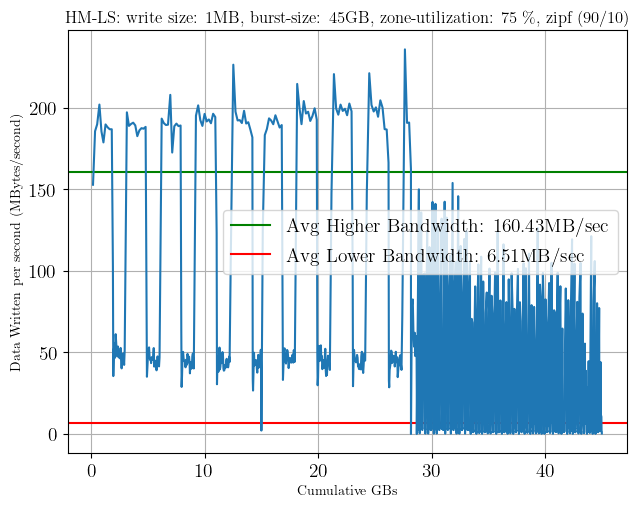

The lowest power of 2 beyond which the plot won't go: 1.52587890625e-05, 0.0


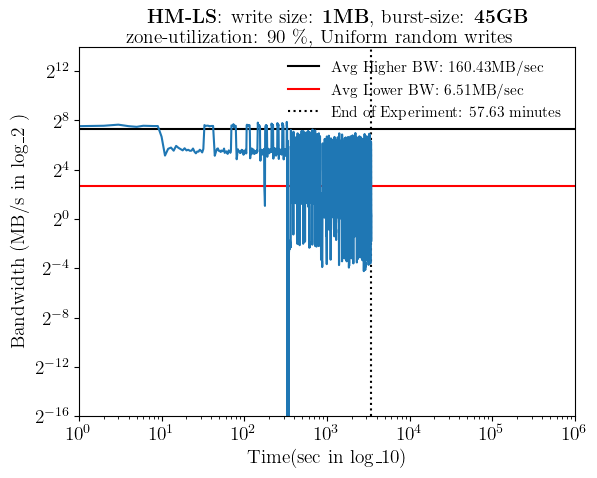

3458


In [83]:
names_latency=['submission_time', 'duration', 'op2', 'write_size', 'op3']
columns = ['submission_time', 'duration', 'write_size']

# Step 1: Read the CSV file into a Pandas DataFrame
df = pd.read_csv('/home/surbhi/measurements/worst_case/lsdm/lsdm-util/90Util/1MB/8TB/uniform/45GB/lat_log_avg_lat.1.log', names=names_latency, usecols=columns)

df['submission_time'] = np.floor(df['submission_time'] - df.iloc[0].submission_time)
df['duration'] = df['duration']/1e6 #convert ns to ms
df['completion_time'] = np.floor(df['submission_time'] + df['duration'])

# Step 3: Determine the start and end time of the entire test
start_time = int(df['submission_time'].min())
end_time = int(df['completion_time'].max())


# Step 4: Create new DataFrames to represent each  millisecond between the start and end time of the entire test
data_written_ms = pd.DataFrame(index=range(start_time, end_time + 1, 1), columns=['data_written_bytes'])
data_written_ms['data_written_bytes'] = 0

# Step 5: Iterate through each write request, calculate the data size for each time interval, and update the corresponding entries in the DataFrames
for index, row in df.iterrows():
    duration = row['duration']
    start = int(row['submission_time'])
    end = start+math.floor(duration)
    
    payload = (1024 * 1024)
    write_rate_per_ms = payload / max(duration, 1.)
    assert(write_rate_per_ms <= payload)
    residue = payload - write_rate_per_ms * math.floor(duration)
    assert (payload >= (write_rate_per_ms * math.floor(duration)))
    data_written_ms.loc[start:end-1] += write_rate_per_ms
    # residue could be zero when last == end
    data_written_ms.loc[end] += residue

print(index)
data_written_ms.reset_index(drop=True, inplace=True)

chunk_size = 10000
results = []
for i in range(0, len(data_written_ms), chunk_size):
    chunk = data_written_ms.iloc[i:i+chunk_size]
    result = chunk.groupby(custom_grouping).sum()
    results.append(result)

df_grouped = pd.concat(results)

# Reset the index to make it a regular column
df_grouped.reset_index(inplace=True)
df_grouped['cumulative_gb'] = df_grouped['data_written_bytes'].cumsum() / (1024 ** 3)
df_grouped['data_written_bytes'] = df_grouped['data_written_bytes'] / (1024 ** 2) 
#
#data_array = df_grouped['data_written_bytes'].values.reshape(-1, 1)
#print(df_grouped.describe())
#print(df_grouped.info())
print("Min Idx: \n" + str(df_grouped['data_written_bytes'].idxmin()))

data_array = df_grouped['data_written_bytes'].values.reshape(-1, 1)
kmeans = KMeans(n_clusters=2)
kmeans.fit(data_array)
# Get the cluster centers
cluster_centers = kmeans.cluster_centers_.flatten()
# Sort cluster centers to get the lowest and highest modes
cluster_centers.sort()
# Calculate the average of each mode
average_mode1 = cluster_centers[0]
average_mode2 = cluster_centers[1]
print("Average1: " + str(round(average_mode1, )))
print("Average2: " + str(round(average_mode2, )))
avg_bw_str1 = str(round(average_mode1, 2)) + 'MB/sec'
avg_bw_str2 = str(round(average_mode2, 2)) + 'MB/sec'
fig, ax = plt.subplots()
plt.axhline(y=average_mode2, color='g', linestyle='-', label='Avg Higher Bandwidth: ' + avg_bw_str2)
plt.axhline(y=average_mode1, color='r', linestyle='-', label='Avg Lower Bandwidth: ' + avg_bw_str1)

# Plot vertical lines at x where y is higher than the threshold

#cid = plt.figure().canvas.mpl_connect('button_press_event', mouse_event)

plt.legend(loc='center right', fontsize=14)
# Plot the data size over time for each resolution
#plt.figure(figsize=(8, 6), dpi=80)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlim(0, 8000)
#plt.ylim(0, 250)
plt.tight_layout()
plt.plot(df_grouped['cumulative_gb'], df_grouped['data_written_bytes'])
#plt.plot(df_grouped.index, df_grouped['data_written_bytes'])
plt.xlabel('Cumulative GBs')
plt.ylabel('Data Written per second (MBytes/second)')
plt.grid(True)  # Optionally, add grid lines
plt.title("HM-LS: write size: 1MB, burst-size: 45GB, zone-utilization: 75 \%, zipf (90/10)")
    
plt.savefig('/home/surbhi/github/surbhi-plots/new/LSDM/1M_90Util_uniform_HMLS_CGBW.png', bbox_inches='tight')
plt.show()

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.axhline(y=average_mode2, color='black', linestyle='-', label='Avg Higher BW: ' + avg_bw_str2)
plt.axhline(y=average_mode1, color='r', linestyle='-', label='Avg Lower BW: ' + avg_bw_str1)
plt.legend(loc='center right', fontsize=14)
#plt.plot(df_grouped.index, df_grouped['data_written_bytes'])

#plt.xlabel('Logarithmic (base 10) Time in seconds', fontsize=14)
#plt.ylabel('Logarithmic (base 2) Bandwidth (MB/sec)', fontsize=14)

plt.xlabel('Time(sec in log_{10})', fontsize=14)
plt.ylabel('Bandwidth (MB/s in log_2 )', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#plt.yticks(np.arange(0, 80, 10), fontsize=14)
plt.xscale('log', base=10)

common_yticks = [2**i for i in range(-16, 14, 2)]
plt.yticks(common_yticks)
ax = plt.gca()

# Custom formatter to display ticks as powers of 2
def log2_format(y, pos):
    return f'$2^{{{int(np.log2(y))}}}$' if y > 0 else '0'

# Find the minimum Y-value in the dataset
y_min = min(df_grouped['data_written_bytes'])
# Find the closest lower power of 2
#lowest_power_of_2 = 2 ** np.floor(np.log2(y_min))
lowest_power_of_2 = 2 ** -16
print(f"The lowest power of 2 beyond which the plot won't go: {lowest_power_of_2}, {y_min}")
# Set Y-axis limits to include the full range of ticks
# Set Y-axis limits
ax.set_ylim(lowest_power_of_2 , 2**14)
#ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(log2_format))
plt.yscale('log', base=2)
# Set the same number of ticks for all plots

# Custom formatter to display ticks as powers of 10
def log10_format(y, pos):
    return f'$10^{{{int(np.log10(y))}}}$' if y > 0 else '0'

common_ticks = [10**0, 10**1, 10**2, 10**3, 10**4, 10**5, 10**6]
ax.get_xaxis().set_major_formatter(ticker.FuncFormatter(log10_format))
ax.set_xlim(10**0, 10**5)
plt.xticks(common_ticks)

#plt.yscale('log', base=10)
#plt.yticks(np.arange(0, 300, 50), fontsize=14)
#plt.xticks(np.arange(0, 8000, 1000), fontsize=14)
#plt.grid(True)  # Optionally, add grid lines

xmax = df_grouped.index.max()
# Add a vertical line at the end of the experiment
xmin = round(int(xmax)/60, 2)
ax.axvline(x=xmax, color='black', linestyle=':', label='End of Experiment: ' + str(xmin) + ' minutes')
plt.legend(loc='upper right', fontsize=11, frameon=False)

plt.plot(df_grouped.index, df_grouped['data_written_bytes'])
plt.title(r"$\textbf{HM-LS}$: write size: $\textbf{1MB}$, burst-size: $\textbf{45GB}$ \\ zone-utilization: 90 \%, Uniform random writes",fontsize=14)    
plt.savefig('/home/surbhi/github/surbhi-plots/new/LSDM/1M_90Util_uniform_lsdm_BW.pdf', bbox_inches='tight', format="pdf")
plt.savefig('/home/surbhi/Downloads/1M_90Util_uniform_LSDM_BW.pdf', bbox_inches='tight', format="pdf")
#plt.savefig('/home/surbhi/Downloads/1M_90Util_uniform_HMLS_Inner_BW.jpeg', bbox_inches='tight')
plt.show()
print(str(df_grouped.index[-1]))

In [84]:
names_latency=['submission_time', 'duration', 'op2', 'write_size', 'op3']
columns = ['submission_time', 'duration', 'write_size']

# Step 1: Read the CSV file into a Pandas DataFrame
df = pd.read_csv('/home/surbhi/measurements/worst_case/lsdm/lsdm-util/25Util/1MB/8TB/uniform/45GB/lat_log_avg_lat.1.log', names=names_latency, usecols=columns)

df['submission_time'] = np.floor(df['submission_time'] - df.iloc[0].submission_time)
df['duration'] = df['duration']/1e6 #convert ns to ms
df['completion_time'] = np.floor(df['submission_time'] + df['duration'])

# Step 3: Determine the start and end time of the entire test
start_time = int(df['submission_time'].min())
end_time = int(df['completion_time'].max())


# Step 4: Create new DataFrames to represent each  millisecond between the start and end time of the entire test
data_written_ms = pd.DataFrame(index=range(start_time, end_time + 1, 1), columns=['data_written_bytes'])
data_written_ms['data_written_bytes'] = 0

# Step 5: Iterate through each write request, calculate the data size for each time interval, and update the corresponding entries in the DataFrames
for index, row in df.iterrows():
    duration = row['duration']
    start = int(row['submission_time'])
    end = start+math.floor(duration)
    
    payload = (1024 * 1024)
    write_rate_per_ms = payload / max(duration, 1.)
    assert(write_rate_per_ms <= payload)
    residue = payload - write_rate_per_ms * math.floor(duration)
    assert (payload >= (write_rate_per_ms * math.floor(duration)))
    data_written_ms.loc[start:end-1] += write_rate_per_ms
    # residue could be zero when last == end
    data_written_ms.loc[end] += residue

print(index)
data_written_ms.reset_index(drop=True, inplace=True)

chunk_size = 10000
results = []
for i in range(0, len(data_written_ms), chunk_size):
    chunk = data_written_ms.iloc[i:i+chunk_size]
    result = chunk.groupby(custom_grouping).sum()
    results.append(result)

df_grouped = pd.concat(results)

# Reset the index to make it a regular column
df_grouped.reset_index(inplace=True)
df_grouped['cumulative_gb'] = df_grouped['data_written_bytes'].cumsum() / (1024 ** 3)
df_grouped['data_written_bytes'] = df_grouped['data_written_bytes'] / (1024 ** 2) 
#
#data_array = df_grouped['data_written_bytes'].values.reshape(-1, 1)
#print(df_grouped.describe())
#print(df_grouped.info())
print("Min Idx: \n" + str(df_grouped['data_written_bytes'].idxmin()))

data_array = df_grouped['data_written_bytes'].values.reshape(-1, 1)
kmeans = KMeans(n_clusters=2)
kmeans.fit(data_array)
# Get the cluster centers
cluster_centers = kmeans.cluster_centers_.flatten()
# Sort cluster centers to get the lowest and highest modes
cluster_centers.sort()
# Calculate the average of each mode
average_mode1 = cluster_centers[0]
average_mode2 = cluster_centers[1]
print("Average1: " + str(round(average_mode1, )))
print("Average2: " + str(round(average_mode2, )))
avg_bw_str1 = str(round(average_mode1, 2)) + 'MB/sec'
avg_bw_str2 = str(round(average_mode2, 2)) + 'MB/sec'
fig, ax = plt.subplots()

plt.xscale('log', base=10)
plt.yscale('log', base=2)

# Custom formatter to display ticks as powers of 10
def log10_format(y, pos):
    return f'$10^{{{int(np.log10(y))}}}$' if y > 0 else '0'

common_ticks = [10**0, 10**1, 10**2, 10**3, 10**4, 10**5, 10**6]
ax.get_xaxis().set_major_formatter(ticker.FuncFormatter(log10_format))
ax.set_xlim(10**0, 10**5)
plt.xticks(common_ticks)


# Find the minimum Y-value in the dataset
y_min = min(df_grouped['data_written_bytes'])
# Find the closest lower power of 2
#lowest_power_of_2 = 2 ** np.floor(np.log2(y_min))
lowest_power_of_2 = 2 ** -16
print(f"The lowest power of 2 beyond which the plot won't go: {lowest_power_of_2}, {y_min}")
# Set Y-axis limits to include the full range of ticks

ax.set_ylim(lowest_power_of_2 , 2**14)

def log2_format(y, pos):
    return f'$2^{{{int(np.log2(y))}}}$' if y > 0 else '0'

#ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(log2_format))
# Custom formatter to display ticks as powers of 2

common_yticks = [2**i for i in range(-16, 14, 4)]
plt.yticks(common_yticks)

#plt.axhline(y=average_mode2, color='g', linestyle='-', label='Avg Higher Bandwidth: ' + avg_bw_str2)
#plt.axhline(y=average_mode1, color='r', linestyle='-', label='Avg Lower Bandwidth: ' + avg_bw_str1)

# Plot vertical lines at x where y is higher than the threshold

#cid = plt.figure().canvas.mpl_connect('button_press_event', mouse_event)

plt.legend(loc='center right', fontsize=14)
# Plot the data size over time for each resolution
#plt.figure(figsize=(8, 6), dpi=80)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlim(0, 8000)
#plt.ylim(0, 250)



plt.tight_layout()
#plt.plot(df_grouped['cumulative_gb'], df_grouped['data_written_bytes'])
#plt.plot(df_grouped.index, df_grouped['data_written_bytes'])
#plt.xlabel('Cumulative GBs')
#plt.ylabel('Data Written per second (MBytes/second)')
#plt.title("HM-LS: write size: 1MB, burst-size: 5GB, zone-utilization: 25 \%, \\ zipf (90/10) (Inner writes)")
    
#plt.savefig('/home/surbhi/github/surbhi-plots/new/LSDM/1M_25Util_Uniform_HMLS_Inner_CGBW.png', bbox_inches='tight')
#plt.show()

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.axhline(y=average_mode2, color='black', linestyle='-', label='Avg Higher BW: ' + avg_bw_str2)
plt.axhline(y=average_mode1, color='r', linestyle='-', label='Avg Lower BW: ' + avg_bw_str1)
plt.legend(loc='center right', fontsize=14)

plt.xlabel('Time(sec in log_{10})', fontsize=14)
plt.ylabel('Bandwidth (MB/s in log_2 )', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


xmax = df_grouped.index.max()
# Add a vertical line at the end of the experiment
xmin = round(int(xmax)/60, 2)
ax.axvline(x=xmax, color='black', linestyle=':', label='End of Experiment: ' + str(xmin) + ' minutes')
plt.legend(loc='upper right', fontsize=11, frameon=False)

plt.plot(df_grouped.index, df_grouped['data_written_bytes'])
plt.title(r"$\textbf{HM-LS}$: write size: $\textbf{1MB}$, burst-size: $\textbf{45GB}$ \\ zone-utilization: 25 \%, Uniform Random (Inner writes)",fontsize=14)    
#plt.savefig('/home/surbhi/github/surbhi-plots/new/LSDM/1M_75Util_Uniform_lsdm_Inner_BW.pdf', bbox_inches='tight', format="pdf")
plt.savefig('/home/surbhi/Downloads/1M_25UtilUniform_LSDM_BW.pdf', bbox_inches='tight', format="pdf")
#plt.savefig('/home/surbhi/Downloads/1M_25Util_Uniform_HMLS_BW.jpeg', bbox_inches='tight')
plt.show()
print(str(df_grouped.index[-1]))

/tmp/ipykernel_19172/558509023.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[8749.60304213 8749.60304213 8749.60304213 8749.60304213 8749.60304213
 8749.60304213 8749.60304213 8749.60304213 8749.60304213 8749.60304213
 8749.60304213 8749.60304213 8749.60304213 8749.60304213 8749.60304213
 8749.60304213 8749.60304213 8749.60304213 8749.60304213 8749.60304213
 8749.60304213 8749.60304213 8749.60304213 8749.60304213 8749.60304213
 8749.60304213 8749.60304213 8749.60304213 8749.60304213 8749.60304213
 8749.60304213 8749.60304213 8749.60304213 8749.60304213 8749.60304213
 8749.60304213 8749.60304213 8749.60304213 8749.60304213 8749.60304213
 8749.60304213 8749.60304213 8749.60304213 8749.60304213 8749.60304213
 8749.60304213 8749.60304213 8749.60304213 8749.60304213 8749.60304213
 8749.60304213 8749.60304213 8749.60304213 8749.60304213 8749.60304213
 8749.60304213 8749.60304213 8749.60304213 8749.60304213 8749.6

/tmp/ipykernel_19172/3053806522.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[6411.46040721 6411.46040721 6411.46040721 6411.46040721 6411.46040721
 6411.46040721 6411.46040721 6411.46040721 6411.46040721 6411.46040721
 6411.46040721 6411.46040721 6411.46040721 6411.46040721 6411.46040721
 6411.46040721 6411.46040721 6411.46040721 6411.46040721 6411.46040721
 6411.46040721 6411.46040721 6411.46040721 6411.46040721 6411.46040721
 6411.46040721 6411.46040721 6411.46040721 6411.46040721 6411.46040721
 6411.46040721 6411.46040721 6411.46040721 6411.46040721 6411.46040721
 6411.46040721 6411.46040721 6411.46040721 6411.46040721 6411.46040721
 6411.46040721 6411.46040721 6411.46040721 6411.46040721 6411.46040721
 6411.46040721 6411.46040721 6411.46040721 6411.46040721 6411.46040721
 6411.46040721 6411.46040721 6411.46040721 6411.46040721 6411.46040721
 6411.46040721 6411.46040721 6411.46040721 6411.46040721 6411.

46079
Min Idx: 
319
Average1: 2
Average2: 177


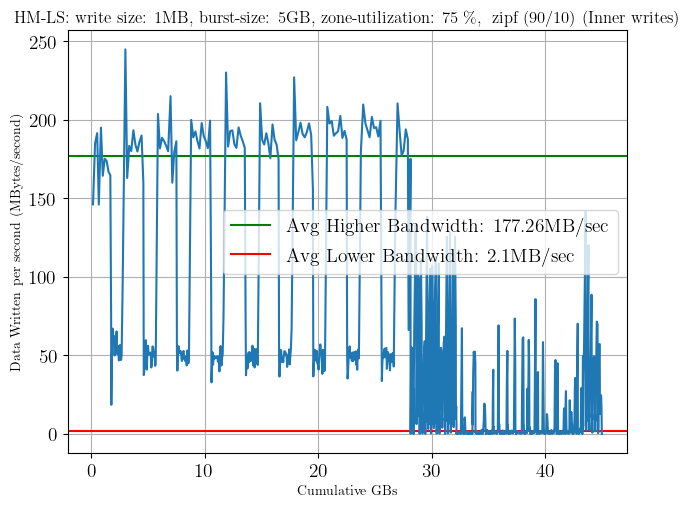

The lowest power of 2 beyond which the plot won't go: 1.52587890625e-05, 0.0


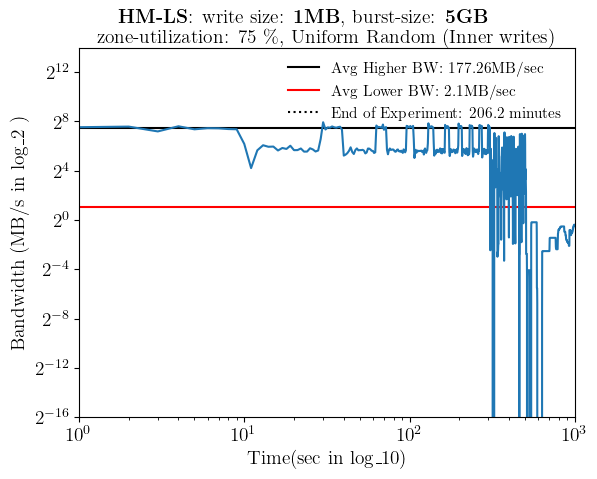

12372


In [82]:
names_latency=['submission_time', 'duration', 'op2', 'write_size', 'op3']
columns = ['submission_time', 'duration', 'write_size']

# Step 1: Read the CSV file into a Pandas DataFrame
df = pd.read_csv('/home/surbhi/measurements/worst_case/lsdm/lsdm-util/75Util/1MB/8TB/uniform/45GB/lat_log_avg_lat.1.log', names=names_latency, usecols=columns)

df['submission_time'] = np.floor(df['submission_time'] - df.iloc[0].submission_time)
df['duration'] = df['duration']/1e6 #convert ns to ms
df['completion_time'] = np.floor(df['submission_time'] + df['duration'])

# Step 3: Determine the start and end time of the entire test
start_time = int(df['submission_time'].min())
end_time = int(df['completion_time'].max())


# Step 4: Create new DataFrames to represent each  millisecond between the start and end time of the entire test
data_written_ms = pd.DataFrame(index=range(start_time, end_time + 1, 1), columns=['data_written_bytes'])
data_written_ms['data_written_bytes'] = 0

# Step 5: Iterate through each write request, calculate the data size for each time interval, and update the corresponding entries in the DataFrames
for index, row in df.iterrows():
    duration = row['duration']
    start = int(row['submission_time'])
    end = start+math.floor(duration)
    
    payload = (1024 * 1024)
    write_rate_per_ms = payload / max(duration, 1.)
    assert(write_rate_per_ms <= payload)
    residue = payload - write_rate_per_ms * math.floor(duration)
    assert (payload >= (write_rate_per_ms * math.floor(duration)))
    data_written_ms.loc[start:end-1] += write_rate_per_ms
    # residue could be zero when last == end
    data_written_ms.loc[end] += residue

print(index)
data_written_ms.reset_index(drop=True, inplace=True)

chunk_size = 10000
results = []
for i in range(0, len(data_written_ms), chunk_size):
    chunk = data_written_ms.iloc[i:i+chunk_size]
    result = chunk.groupby(custom_grouping).sum()
    results.append(result)

df_grouped = pd.concat(results)

# Reset the index to make it a regular column
df_grouped.reset_index(inplace=True)
df_grouped['cumulative_gb'] = df_grouped['data_written_bytes'].cumsum() / (1024 ** 3)
df_grouped['data_written_bytes'] = df_grouped['data_written_bytes'] / (1024 ** 2) 
#
#data_array = df_grouped['data_written_bytes'].values.reshape(-1, 1)
#print(df_grouped.describe())
#print(df_grouped.info())
print("Min Idx: \n" + str(df_grouped['data_written_bytes'].idxmin()))

data_array = df_grouped['data_written_bytes'].values.reshape(-1, 1)
kmeans = KMeans(n_clusters=2)
kmeans.fit(data_array)
# Get the cluster centers
cluster_centers = kmeans.cluster_centers_.flatten()
# Sort cluster centers to get the lowest and highest modes
cluster_centers.sort()
# Calculate the average of each mode
average_mode1 = cluster_centers[0]
average_mode2 = cluster_centers[1]
print("Average1: " + str(round(average_mode1, )))
print("Average2: " + str(round(average_mode2, )))
avg_bw_str1 = str(round(average_mode1, 2)) + 'MB/sec'
avg_bw_str2 = str(round(average_mode2, 2)) + 'MB/sec'
fig, ax = plt.subplots()
plt.axhline(y=average_mode2, color='g', linestyle='-', label='Avg Higher Bandwidth: ' + avg_bw_str2)
plt.axhline(y=average_mode1, color='r', linestyle='-', label='Avg Lower Bandwidth: ' + avg_bw_str1)

# Plot vertical lines at x where y is higher than the threshold

#cid = plt.figure().canvas.mpl_connect('button_press_event', mouse_event)

plt.legend(loc='center right', fontsize=14)
# Plot the data size over time for each resolution
#plt.figure(figsize=(8, 6), dpi=80)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlim(0, 8000)
#plt.ylim(0, 250)
plt.tight_layout()
plt.plot(df_grouped['cumulative_gb'], df_grouped['data_written_bytes'])
#plt.plot(df_grouped.index, df_grouped['data_written_bytes'])
plt.xlabel('Cumulative GBs')
plt.ylabel('Data Written per second (MBytes/second)')
plt.grid(True)  # Optionally, add grid lines
plt.title("HM-LS: write size: 1MB, burst-size: 5GB, zone-utilization: 75 \%, \\ zipf (90/10) (Inner writes)")
    
plt.savefig('/home/surbhi/github/surbhi-plots/new/LSDM/1M_75Util_Uniform_HMLS_Inner_CGBW.png', bbox_inches='tight')
plt.show()

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.axhline(y=average_mode2, color='black', linestyle='-', label='Avg Higher BW: ' + avg_bw_str2)
plt.axhline(y=average_mode1, color='r', linestyle='-', label='Avg Lower BW: ' + avg_bw_str1)
plt.legend(loc='center right', fontsize=14)
#plt.plot(df_grouped.index, df_grouped['data_written_bytes'])

#plt.xlabel('Logarithmic (base 10) Time in seconds', fontsize=14)
#plt.ylabel('Logarithmic (base 2) Bandwidth (MB/sec)', fontsize=14)

plt.xlabel('Time(sec in log_{10})', fontsize=14)
plt.ylabel('Bandwidth (MB/s in log_2 )', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#plt.yticks(np.arange(0, 80, 10), fontsize=14)
plt.xscale('log', base=10)

common_yticks = [2**i for i in range(-16, 14, 2)]
plt.yticks(common_yticks)
ax = plt.gca()

# Custom formatter to display ticks as powers of 2
def log2_format(y, pos):
    return f'$2^{{{int(np.log2(y))}}}$' if y > 0 else '0'

# Find the minimum Y-value in the dataset
y_min = min(df_grouped['data_written_bytes'])
# Find the closest lower power of 2
#lowest_power_of_2 = 2 ** np.floor(np.log2(y_min))
lowest_power_of_2 = 2 ** -16
print(f"The lowest power of 2 beyond which the plot won't go: {lowest_power_of_2}, {y_min}")
# Set Y-axis limits to include the full range of ticks
# Set Y-axis limits
ax.set_ylim(lowest_power_of_2 , 2**14)
#ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(log2_format))
plt.yscale('log', base=2)
# Set the same number of ticks for all plots

# Custom formatter to display ticks as powers of 10
def log10_format(y, pos):
    return f'$10^{{{int(np.log10(y))}}}$' if y > 0 else '0'

common_ticks = [10**0, 10**1, 10**2, 10**3]
ax.get_xaxis().set_major_formatter(ticker.FuncFormatter(log10_format))
ax.set_xlim(10**0, 10**3)
plt.xticks(common_ticks)

#plt.yscale('log', base=10)
#plt.yticks(np.arange(0, 300, 50), fontsize=14)
#plt.xticks(np.arange(0, 8000, 1000), fontsize=14)
#plt.grid(True)  # Optionally, add grid lines

xmax = df_grouped.index.max()
# Add a vertical line at the end of the experiment
xmin = round(int(xmax)/60, 2)
ax.axvline(x=xmax, color='black', linestyle=':', label='End of Experiment: ' + str(xmin) + ' minutes')
plt.legend(loc='upper right', fontsize=11, frameon=False)

plt.plot(df_grouped.index, df_grouped['data_written_bytes'])
plt.title(r"$\textbf{HM-LS}$: write size: $\textbf{1MB}$, burst-size: $\textbf{5GB}$ \\ zone-utilization: 75 \%, Uniform Random (Inner writes)",fontsize=14)    
#plt.savefig('/home/surbhi/github/surbhi-plots/new/LSDM/1M_75Util_Uniform_lsdm_Inner_BW.pdf', bbox_inches='tight', format="pdf")
#plt.savefig('/home/surbhi/Downloads/1M_90UtilUniform_LSDM_Inner_BW.pdf', bbox_inches='tight', format="pdf")
#plt.savefig('/home/surbhi/Downloads/1M_75Util_Uniform_HMLS_Inner_BW.jpeg', bbox_inches='tight')
plt.show()
print(str(df_grouped.index[-1]))